<a href="https://colab.research.google.com/github/HakanBayazitHabes/Deep_Dream_AI/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dream Üretme

**Kaynak:** [fchollet](https://twitter.com/fchollet)<br>


"Derin rüya", bir görüntü sınıflandırma modeli almak ve bu girdi için belirli katmanların (ve bazen belirli katmanlardaki belirli birimlerin) aktivasyonlarını en üst düzeye çıkarmak için bir girdi görüntüsü üzerinde gradyan yükselmesi çalıştırmaktan oluşan bir görüntü filtreleme tekniğidir. Halüsinasyon benzeri görseller üretir.

İlk kez Temmuz 2015'te Google'dan Alexander Mordvintsev tarafından tanıtıldı.

İşlem Adımları:

- Orijinal görüntüyü yükle
- işlem sayısını belirle buna oktav diyoruz ("octaves"),
küçükten büyüğe doğru belirlenmeli.
- Orijinal görüntüyü en küçük skalaya göre yeniden boyutlandır.
- Bütün skalalar için en küçünden başla:
    - Gradyan yükseliş algoritmasını başlat
    - Göntüleri upscale ederek büyüt
    - Yükseltme zamanında kaybolan detayı yeniden düşün
- Orijinal görüntünün boyutuna gelince işlemleri durdur.

Yükseltme sırasında kaybolan ayrıntıyı elde etmek için orijinal görüntüyü alır, küçültür, ölçeklendirir ve sonucu (yeniden boyutlandırılmış) orijinal görüntüyle karşılaştırırız.


## Kütüphanelerin Yüklenmesi ve Giriş Görüntüsünün Okunması


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("yeni.jpg", "https://images.unsplash.com/photo-1474418397713-7ede21d49118?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=736&q=80")
result_prefix = "yeni_dream"

#Bunlar, aktivasyonu en üst düzeye çıkarmaya çalıştığımız katmanların adları
#ve en üst düzeye çıkarmaya çalıştığımız son kayıptaki ağırlıklarıdır.

#Yeni görsel efektler elde etmek için bu ayarı düzenleyebilirsiniz.
layer_settings = {
    "mixed4": 2.0,
    "mixed5": 3.5,
    "mixed6": 2.0,
    "mixed7": 3.5,
}

# Bu hiperparametrelerle oynamak da yeni efektler elde etmenizi sağlar
step = 0.01  # Gradyan çıkış adımı boyutu
num_octave = 3  # Gradyan yükselmesinin çalıştırılacağı ölçek sayısı
octave_scale = 1.4  # Ölçekler arasındaki boyut oranı
iterations = 20  # Ölçek başına çıkış adımı sayısı
max_loss = 15.0


32836/32836 [==============================] - 0s 0us/step


Giriş Görüntüsü:


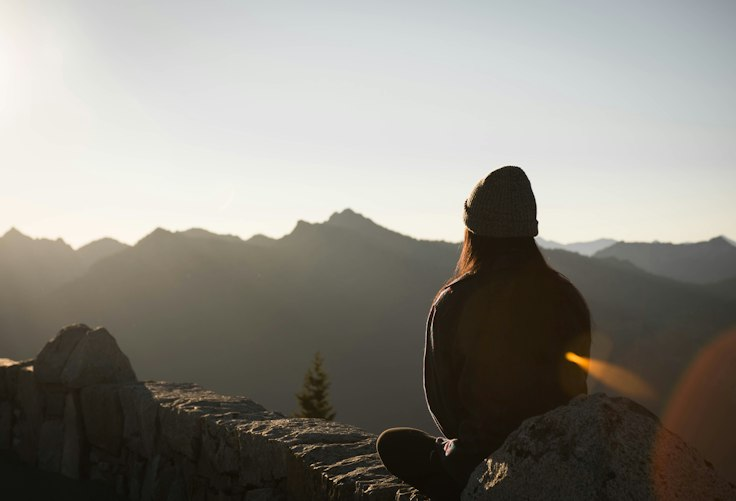

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))


Bazı görüntü önişleme / yeniden işleme yardımcı programlarını ayarlayalım:


In [3]:

def preprocess_image(image_path):
    # Resimleri uygun dizilere açmak, yeniden boyutlandırmak ve biçimlendirmek için Util işlevi
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # NumPy dizisini geçerli bir görüntüye dönüştürmek için Util işlevi.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Inceptionv3 ön işlemesini geri alma
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Deep Dream kaybını hesapla

İlk olarak, bir giriş görüntüsü verilen hedef katmanlarımızın aktivasyonunu almak için bir özellik çıkarma modeli oluşturun.


In [4]:
# Önceden eğitilmiş ImageNet ağırlıklarıyla dolu bir InceptionV3 modeli oluşturun
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Her "anahtar" katmanın sembolik çıktılarını alın
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Her hedef katman için etkinleştirme değerlerini döndüren bir model oluşturun (dict olarak)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


87910968/87910968 [==============================] - 4s 0us/step


Gerçek kayıp hesaplaması çok basittir:


In [5]:

def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Kaybı başlat
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # Sınırda olmayan pikselleri yalnızca kayda dahil ederek kenarlık yapaylıklarından kaçınırız.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss



## Bir oktav için gradyan çıkış döngüsünü ayarlayın.


In [6]:

@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Gradyanları Hesapla.
    grads = tape.gradient(loss, img)
    # Gradyanları Normalize Et.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img



## Farklı oktavlar üzerinde yineleyerek eğitim döngüsünü çalıştırın


In [7]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))


Processing octave 0 with shape (255, 375)
... Loss value at step 0: 1.00
... Loss value at step 1: 1.15
... Loss value at step 2: 1.47
... Loss value at step 3: 1.79
... Loss value at step 4: 2.13
... Loss value at step 5: 2.42
... Loss value at step 6: 2.76
... Loss value at step 7: 3.06
... Loss value at step 8: 3.39
... Loss value at step 9: 3.68
... Loss value at step 10: 3.99
... Loss value at step 11: 4.33
... Loss value at step 12: 4.67
... Loss value at step 13: 4.95
... Loss value at step 14: 5.29
... Loss value at step 15: 5.55
... Loss value at step 16: 5.86
... Loss value at step 17: 6.08
... Loss value at step 18: 6.47
... Loss value at step 19: 6.68
Processing octave 1 with shape (357, 525)
... Loss value at step 0: 1.82
... Loss value at step 1: 2.77
... Loss value at step 2: 3.54
... Loss value at step 3: 4.21
... Loss value at step 4: 4.81
... Loss value at step 5: 5.40
... Loss value at step 6: 5.92
... Loss value at step 7: 6.53
... Loss value at step 8: 7.08
... Los

Sonuçları görselleşirin


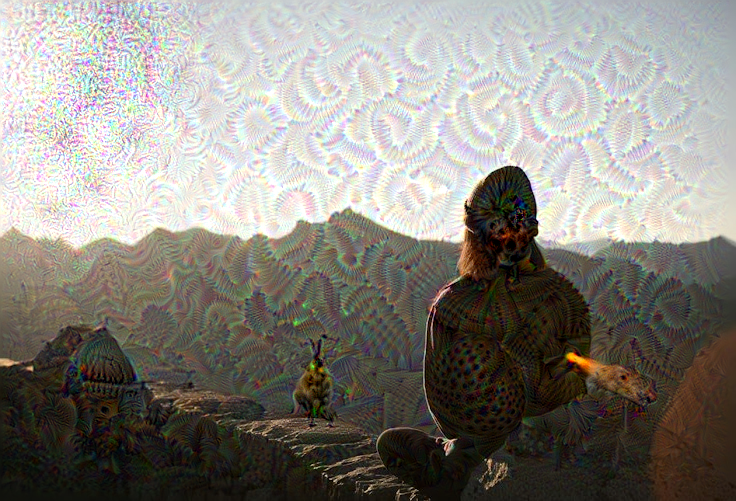

In [8]:
display(Image(result_prefix + ".png"))
